# Couplings Inference

In this notebook, we will implement the functions needed to extract effective couplings from the parameters of Potts-Bernoulli Restricted Boltzmann Machines, as described in [1].

In [1]:
# Importing libraries
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import h5py
import utilities as utils
from torch import Tensor
from typing import Callable, Tuple
from collections import OrderedDict

from tqdm import tqdm # to compute the time bar

In [2]:
# use LaTeX fonts in the plot
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

# Introduction

## Effective Couplings of the Restricted Boltzmann Machine

<p align="center">
<img src="https://github.com/DsysDML/couplings_inference/blob/main/figures/RBM_figure.png?raw=true" alt="RBM figure" width="50%">
</p>

**Fig-1. Architecture of the Potts-Bernoulli Restricted Boltzmann Machine (PB-RBM).** Bitartite lattice with hidden variables $h_a$, that can take only two possible values (typically 0 an 1); visible variables $v_i$ take on $q$ different states or colors.

The RBM is an energy-based model estructured as bipartite neural network. In this model, the visible layer $\boldsymbol{v} \!=\! \{ v_i \}_{i=1}^{N_v}$ represents the data, while the hidden layer $\boldsymbol{h} \!=\! \{ h_i \}_{i=1}^{N_h}$ accounts the interactions among the visible variables. The probability of a given RBM configuration $\{ \boldsymbol{v}, \boldsymbol{h} \}$ is determined by the Boltzmann distribution i.,e.
$$
p(\boldsymbol{v}, \boldsymbol{h}) \!\propto\! e^{-\mathcal{H}(\boldsymbol{v}, \boldsymbol{h})},
$$
where $\mathcal{H} (\boldsymbol{v}, \boldsymbol{h})$ is the _energy function_ or _Hamiltonian_. Here, we define the hidden nodes as Bernoulli variables, i.e., $h_a \!\in\! \{0,1\}$, and visible nodes as categorical variables, or Potts "spins", which can take on $q$ states, i.e., $v_i \!\in\! \{1, \dots, q \}$. Hence, the Hamiltonian of such a model is 

$$
\mathcal{H}(\boldsymbol{v}, \boldsymbol{h}) = -\sum_{i, a, \mu} W_{ia}^{\mu} h_a \delta_{\mu}^{v_i} - \sum_{i, \mu} b_{i}^{\mu} \delta_{\mu}^{v_i} - \sum_{a} c_a h_a.
\tag{1}
$$

In the above we used $\delta$ to denote the Kronecker delta, and $\boldsymbol{\Theta} \!\equiv\! \{ \boldsymbol{W}, \boldsymbol{b}, \boldsymbol{c} \}$ are the model parameters. Marginalizing Eq. $(1)$ one can obtain the following Hamiltonian:

$$
\mathcal{H}(\boldsymbol{v}) =  - \sum_{i,\mu} b_i^\mu \delta_\mu^{v_i} - \sum_a \ln \left(1 + e^{ c_a + \sum_{i, \mu} W_{ia}^{\mu} \delta_\mu^{v_i}} \right).
\tag{2}
$$

In the Ref. [1], we expanded Eq. $(2)$ as

$$
\mathcal{H} (\boldsymbol{v}) 
= - \sum_{i, \mu} H_i^\mu \delta_\mu^{v_i} - \sum_{1 \le i_1 < i_2 \le N_v} \sum_{\mu_1, \mu_2} \! \! J_{ i_1 i_2}^{\mu_1 \mu_2} \delta_{\mu_1}^{v_{i_1}} \delta_{\mu_2}^{v_{i_2}} + \sum_{1 \le i_1 < i_2 < i_3 \le N_v} \sum_{\mu_1, \mu_2, \mu_3} J_{ i_1 i_2 i_3}^{\mu_1 \mu_2 \mu_3} \delta_{\mu_1}^{v_{i_1}} \delta_{\mu_2}^{v_{i_2}} \delta_{\mu_3}^{v_{i_3}} \dots,
$$

with effective couplings (in the zero-sum gauge) given by

$$
J_{i_1 \dots i_n}^{\mu_1 \dots \mu_n}  
    = \sum_{K \subseteq [n] } (-1)^{n - |K|} \Bigg[
    \frac{1}{q^{N_v}} \sum_{\mu'_1, \dots, \mu'_{N_v}} \sum_a  
     \ln \left( 1 + e^{c_a +  \sum_{ k \in K } W_{i_k a}^{\mu_k} + \sum_{ l \in [N_v] \setminus K} W_{i_l a}^{\mu'_l} } \right) \Bigg],
\tag{3}
$$

where $[n] \equiv \{1,2, \dots, n \}$, and $|\boldsymbol{K}|$ denotes the number of elements (i.e., the cardinality) of $\boldsymbol{K}$.

## Gaussian Approximation

Since Eq. $(3)$ introduces sums of $q^N$ terms, which cannot be done exactly, we must rely on approximations of such expressions. Thus, We can rewrite Eq. $(3)$ as

$$
J_{i_1 \dots i_n}^{\mu_1 \dots \mu_n}  = \sum_{K \subseteq [n]} (-1)^{n-|K|} \frac{1}{q^n} \sum_{\mu'_1, \dots, \mu'_n} \sum_{a} \mathbb{E}_{x \sim X_a^{\setminus \{ i_1 \dots i_n \}}} \left[ \ln \left( 1 + e^{c_a + \sum_{k \in K} W_{i_k a}^{\mu_k} + \sum_{l \in [n] \setminus K} W_{i_l a}^{\mu'_l} + x  } \right)  \right], \tag{4}
$$

where $X_a^{ \setminus \{ i_1, \dots, i_n \}} := \sum_{l = n+1}^{N_{v}} \! {W}_{i_l a}^\ast$ is the random variable with each ${W}_{i_l a}^\ast$ drawn uniformly from $\{ {W}_{i_l a}^\mu : \mu \in [q] \}$. 

Fixing the zero-sum gauge of the RBM parameters (i.e., $\sum_{\mu=1}^q \hat{W}_{i a}^\mu = 0, \ \forall i$), implies setting the mean and the variance of $X_a^{ \setminus \{ i_1, \dots, i_n \}}$ as  $$\mathbb{E}[x] \!=\! 0 \ \ \mathrm{and}  \ \ \mathrm{Var} [x] \!=\! q^{-1} \sum_{l=n+1}^{N_{v}} \sum_{\mu=1}^q  \left( \hat{W}_{i_l a}^{\mu} \right)^2. $$

On a first approximation based on the central limit theorem, and for sufficiently large $N_v$ with small $n$, the expected values in Eq. (4) are regarded as Gaussian integrals. Hence, normalizing $X_a^{\setminus \{i_1, \dots, i_n\}}$ to unit variance, we approximate the expected values of in right-hand side of Eq. (4) as

$$
\begin{align}
& \sum_a \mathbb{E}_{x \sim X_a^{\setminus \{ i_1 \dots i_n \}}} \left[ \ln \left( 1 + e^{c_a + \sum_{k \in K} W_{i_k a}^{\mu_k} + \sum_{l \in [n] \setminus K} W_{i_l a}^{\mu'_l} + x  } \right)  \right] \\
& \qquad \approx
\sum_a \int_{-\infty}^{\infty} Dz \, 
    \ln \left( 1 + e ^{ 
        c_a + \sum_{k=1}^n \hat{W}_{i_k a}^{\mu'_k} 
        + \sqrt{ q^{-1} \sum_{l=n+1}^{N_v} \sum_{\mu=1}^q 
            \big( \hat{W}_{i_l a}^{\mu} \big)^2 } \ z } \right) = \colon T_{i_1 \dots i_n}^{\mu'_1 \dots \mu'_n},
\end{align}
\tag{5}
$$

where $Dz = {e^{-z^2/2}}/{\sqrt{2\pi}} \ dz.$ 

## Loading a PB-RBM model

Let us use an RBM model trained on Multiple Sequence Alignment data (PF00072) to test our functions.

In [3]:
model_fname = './models/PF00072_PCD100_mbs=5000_lr=0.01_Nh=1000_L2=0.001_train=0.6.h5'

# selecting an update to observe
update = utils.get_saved_updates(model_fname)[-1]
W_torch, b_torch, c_torch = utils.get_model_params(model_fname, 
                                                   update, 
                                                   device='cuda:0', 
                                                   dtype=torch.float32)

# it is important to fix the zero-sum gauge in the RBM to get accurate results!
utils.fix_gauge_RBM(W_torch, b_torch, c_torch, gauge='zero-sum')

# Torch Functions

In the following sections, we will numerically implement Eq. $(5)$ on GPUs to compute the effective fields, 2-, and 3-body couplings efficiently.

## Auxiliary Functions

In [4]:
# Gaussian function in torch 
def gaussian(x: Tensor) -> Tensor:
    """
    Return the value of a standard gaussian function.
    
    Args:
        x: Variable at which the gaussian function in evaluated.

    Returns:
        Tensor: exp(-(x^2)/2)/sqrt(2*pi)
    """
    return torch.exp(-0.5 * x**2) / math.sqrt(2 * math.pi)

# softmax function in torch
def softplus(x: Tensor) -> Tensor:
    """
    Compute ln(1 + exp(x)).
    
    Args:
        x: Variable at which the function is evaluated.

    Returns:
       Tensor: ln(1 + exp(x))
    """
    return torch.log(1 + torch.exp(x))

# estimating the average using a numeric Gaussian integral
def est_gaussian_avg(f: Callable, 
                     loc: Tensor, 
                     scale: Tensor, 
                     n_sigma: float, 
                     n_steps: int,
                     sum_last_dim: bool = True) -> Tensor:
    """
    Implement the trapezoid rule of integration to approximate the average 
    of a function over a Gaussian meassure.

    Args:
        f (Function): Function to average.
        loc (Tensor): Location parameter (or mean) of the Gaussian.
        scale (Tensor): Scale parameter (or the standard deviation) of 
            the Gaussian.
        n_sigma (float): Set the wide of the numerical integral in terms 
            of the scale parameter.
        n_steps (int): Number of steps of the numerical integral.
        sum_last_dim (bool): If true, sums over the last dimension.
    
    Returns:
        Tensor: Value of the integral of f between -n_sigma*scale and n_sigma*scale under the gaussian measure.
    """
    # numerical integration
    beta = torch.tensor(n_sigma,
                        dtype = scale.dtype, 
                        device = scale.device)
    alpha = -beta 
    h = (beta-alpha)/n_steps
    I = 0.5*(f(alpha*scale + loc)*gaussian(alpha) 
             + f(beta*scale + loc)*gaussian(beta))
    
    # numerical integral
    for k in range(1, n_steps):
        z = alpha + k*h
        I += f(z*scale + loc)*gaussian(z)
    
    # this sum is useful when the last dimension are the hidden nodes
    if sum_last_dim:
        return torch.sum(h*I, dim=-1)
    else:
        return h*I

## Fields

Here we implement a formula to compute the Gaussian approximation of the field tensor whose elements are given by

$$
\hat{H}_i^\mu = \hat{b}_i^\mu + \hat{J}_i^\mu. 
\tag{7}
$$ 

Following the procedure given above for $n=1$, we leverage the parallelization in GPU to compute a tensor such that
$$
T_{i}^{\mu'} = \sum_a \int_{-\infty}^{\infty} Dz \ \ln \left( 1 + e^{c_a + \hat{W}_{ia}^{\mu'} + \sqrt{q^{-1} \sum_{j (\neq i)} \sum_\mu (\hat{W}_{ja}^{\mu}})^2 \ z } \right) = \sum_a {T_a}_{i}^{\mu'} .
\tag{8}
$$
Then, we can approximate $J_i^\mu$ by
$$
J_i^\mu \approx T_i^\mu - \frac{1}{q} \sum_{\mu'} T_{i}^{\mu'}.
\tag{9}
$$
Finally, we can compute $H_i^\mu$ by replacing $(9)$ in $(7)$.

In [5]:
# fields functions
def T1_zs(W: Tensor, 
          c: Tensor, 
          n_sigma: float, 
          n_steps: int) -> Tensor:
    """
    Compute a 2-rank tensor whose entries are given by the Eq. (8).
    
    Args:
        W (Tensor): Weight matrix (shape: q x Nv x Nh).
        c (Tensor): Hidden fields (shape: Nh).
        n_sigma (float): Set the wide of the numerical integral in terms of the scale parameter of the gaussian.
        n_steps (int): Number of steps of the numerical integral.
    
    Returns:
        Tensor: 2-rank tensor whose entries are defined in Eq. (8) (shape: q x Nv).
    """
    q = W.shape[0]
    
    # bias of the softmax function
    bias = W + c

    # scale parameter of the Gaussian measure
    sd = torch.sqrt((torch.sum(W**2, dim=(0,1)) - torch.sum(W**2, dim=0))/q)

    return est_gaussian_avg(f=softplus, 
                            loc=bias, 
                            scale=sd, 
                            n_sigma=n_sigma, 
                            n_steps=n_steps) # shape: q x Nv

def H_zs(W: Tensor, 
         b: Tensor, 
         c: Tensor, 
         n_sigma: float, 
         n_steps: int) -> Tensor:
    """
    Compute a q x Nv effective field matrix.
    
    Args:
        W (Tensor): Weight matrix (shape: q x Nv x Nh)  
        b (Tensor): Visible fields (shape: q x Nv)
        c (Tensor): Hidden fields (shape: Nh)
        n_sigma (float): Set the wide of the numerical integral in terms of the scale parameter of the gaussian.
        n_steps (int): Number of steps of the numerical integral.

    Returns:
       Tensor: 2-rank tensor of effective fields (shape: q x Nv).
    """
    T1_torch = T1_zs(W, c, n_sigma, n_steps)
    
    return (T1_torch - T1_torch.mean(dim=0) + b) # shape: q x Nv

In [6]:
%%timeit
h_torch = H_zs(W_torch, b_torch, c_torch, n_sigma = 5, n_steps = 20) # q x Nv
torch.cuda.synchronize()
#print(h_torch)

3.83 ms ± 6.58 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 2-Body Couplings

Analogously, for 2-body couplings we can write
$$
T_{i_1 i_2}^{\mu'_1 \mu'_2} = \sum_a \int_{-\infty}^{\infty} Dz \ \ln \left( 1 + e^{c_a + \hat{W}_{i_1 a}^{\mu'_1} + \hat{W}_{i_2 a}^{\mu'_2} + \sqrt{q^{-1} \sum_{j (\neq i_1, i_2)} \sum_\mu \big(\hat{W}_{ja}^{\mu} \big)^2 } \ z } \right) = \sum_a {T_a}_{i_1 i_2}^{\mu'_1 \mu'_2}.
\tag{10}
$$
Thus, we can approximate $J_{i_1 i_2}^{\mu_1 \mu_2}$ by
$$
J_{i_1 i_2}^{\mu_1 \mu_2} \approx T_{i_1 i_2}^{\mu_1 \mu_2} - \frac{1}{q} \left[ \sum_{\mu'_1} T_{i_1 i_2}^{\mu'_1 \mu_2} + \sum_{\mu'_2} T_{i_1 i_2}^{\mu_1 \mu'_2} \right] + \frac{1}{q^2} \sum_{\mu'_1, \mu'_2} T_{i_1 i_2}^{\mu'_1 \mu'_2}.
\tag{11}
$$

In [7]:
# 2-body couplings functions
def T2_zs(W: Tensor, 
          c: Tensor, 
          i1: int, 
          i2: int, 
          n_sigma: float, 
          n_steps: int) -> Tensor:
    """
   Compute the 2-rank tensor whose entries are given by the Eq. (10) for sites i1, i2.
    
    Args:
        W (Tensor): Weight matrix (shape: q x Nv x Nh).    
        c (Tensor): Hidden fields (shape: Nh).
        i1, i2 (int): Visible site index 1, 2.
        n_sigma (float): Set the wide of the numerical integral in terms of the scale parameter of the gaussian.
        n_steps (int): Number of steps of the numerical integral.

    Returns:
        Tensor: 2-rank tensor whose entries are defined in Eq. (10) (shape: q x q).
    """
    W1 = W[:,i1,:]
    W2 = W[:,i2,:]
    q = W.shape[0]

    # bias of the softmax function
    bias = W1.unsqueeze(1) + W2.unsqueeze(0) + c

    # scale parameter of the Gaussian measure
    sd = torch.sqrt((torch.sum(W**2, dim=(0,1)) 
                     - torch.sum(W1**2, dim=0)
                     - torch.sum(W2**2, dim=0)
                    )/q)
    
    return est_gaussian_avg(f=softplus, 
                            loc=bias, 
                            scale=sd, 
                            n_sigma=n_sigma, 
                            n_steps=n_steps) # shape: q x q

def J2_zs(W: Tensor, 
          c: Tensor, 
          i1: int, 
          i2: int, 
          n_sigma: float, 
          n_steps: int) -> Tensor:
    """
    Compute the 2-rank pairwise coupling tensor between sites i1, i2.
    
    Args:
        W (Tensor): Weight matrix (shape: q x Nv x Nh)    
        c (Tensor): Hidden fields (shape: Nh)
        i1, i2 (int): Visible site indexes.
        n_sigma (float): Set the wide of the numerical integral in terms of the scale parameter of the gaussian.
        n_steps (int): Number of steps of the numerical integral

    Returns:
      Tensor: 2-rank pairwise coupling tensor between sites i1, i2 (shape: q x q).
    """
    T2_torch = T2_zs(W, c, i1, i2, n_sigma, n_steps)
    J2_torch = (T2_torch + T2_torch.mean()
                - T2_torch.mean(dim=0).unsqueeze(0) 
                - T2_torch.mean(dim=1).unsqueeze(1) 
               )
    
    return J2_torch # shape: q x q

In [8]:
%%timeit
J2_torch = J2_zs(W_torch, c_torch, 2, 3, n_sigma=5, n_steps=20) # q x q
torch.cuda.synchronize()

1.69 ms ± 8.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
# computating all couplings
q, Nv, _ = W_torch.shape
J2_matrix = np.zeros((q,q,Nv,Nv))
pbar = tqdm(total=int(Nv*(Nv-1)/2), colour='green')
for j1 in range(1, Nv):
    for j2 in range(j1):
        J2_torch = J2_zs(W_torch, c_torch, j1, j2, n_sigma=5, n_steps=20)
        J2_matrix[:,:, j1, j2] = J2_torch.to('cpu').numpy()
        pbar.update(1)
pbar.close()

J2_matrix = J2_matrix + J2_matrix.transpose(1,0,3,2)
# This cell runs in < 10s (in an NVIDIA Geforce RTX 3090 GPU)

100%|██████████| 6216/6216 [00:10<00:00, 583.26it/s]


## 3-body couplings

Finally, the analogous expressions for 3-body couplings are given by

$$
T_{i_1 i_2 i_3}^{\mu'_1 \mu'_2 \mu'_3} = \sum_a \int_{-\infty}^{\infty} Dz \ \ln \left( 1 + e^{c_a + \hat{W}_{i_1 a}^{\mu'_1} + \hat{W}_{i_2 a}^{\mu'_2} + \hat{W}_{i_3 a}^{\mu'_3} + \sqrt{q^{-1} \sum_{j (\neq i_1, i_2, i_3)} \sum_\mu (\hat{W}_{ja}^{\mu} )^2 } \ z } \right) = \sum_a {T_a}_{i_1 i_2 i_3}^{\mu'_1 \mu'_2 \mu'_3} .
\tag{12}
$$
Thus, we can approximate $J_{i_1 i_2}^{\mu_1 \mu_2}$ by
$$
\begin{align}
J_{i_1 i_2 i_3}^{\mu_1 \mu_2 \mu_3} 
& \approx T_{i_1 i_2 i_3}^{\mu_1 \mu_2 \mu_3} - \frac{1}{q} \left[ \sum_{\mu'_1} T_{i_1 i_2 i_3}^{\mu'_1 \mu_2 \mu_3} + \sum_{\mu'_2} T_{i_1 i_2 i_3}^{\mu_1 \mu'_2 \mu_3} + \sum_{\mu'_3} T_{i_1 i_2 i_3}^{\mu_1 \mu_2 \mu'_3} \right] \\
& \qquad + \frac{1}{q^2} \left[ \sum_{\mu'_1, \mu'_2, \mu_3} T_{i_1 i_2 i_3}^{\mu'_1 \mu'_2 \mu_3} +  \sum_{\mu'_1, \mu_2, \mu'_3} T_{i_1 i_2 i_3}^{\mu'_1 \mu_2 \mu'_3} + \sum_{\mu_1, \mu'_2, \mu'_3} T_{i_1 i_2 i_3}^{\mu_1 \mu'_2 \mu'_3} \right] - \frac{1}{q^3} \sum_{\mu'_1, \mu'_2, \mu'_3} T_{i_1 i_2 i_3}^{\mu'_1 \mu'_2 \mu'_3}.
\tag{13}
\end{align}
$$

In [10]:
# 3-body couplings functions
def T3_zs(W: Tensor, 
          c: Tensor, 
          i1: int, 
          i2: int, 
          i3: int, 
          n_sigma: float, 
          n_steps: int) -> Tensor:
    """
    Compute the 3-rank tensor whose entries are given by the Eq. (12) for sites i1, i2, i3.
    
    Args:
        W (Tensor): Weight matrix (shape: q x Nv x Nh).
        c (Tensor): Hidden fields (shape: Nh).
        i1, i2, i3 (int): Visible site indexes.
        n_sigma (float): Set the wide of the numerical integral in terms of the scale 
            parameter of the gaussian.
        n_steps (int): Number of steps of the numerical integral.

    Returns:
        Tensor: 3-rank tensor whose entries are defined in Eq. (12) (shape: q x q x q).
    """
    W1 = W[:,i1,:]
    W2 = W[:,i2,:]
    W3 = W[:,i3,:]
    q = W.shape[0]

    # bias of the softmax function
    bias = (W1.unsqueeze(1).unsqueeze(1) 
            + W2.unsqueeze(1).unsqueeze(0) 
            + W3.unsqueeze(0).unsqueeze(0) 
            + c)

    # scale parameter of the Gaussian measure
    sd = torch.sqrt((torch.sum(W**2, dim=(0,1)) 
                      - torch.sum(W1**2, dim=0)
                      - torch.sum(W2**2, dim=0)
                      - torch.sum(W3**2, dim=0)
                     )/q)

    return est_gaussian_avg(f=softplus, 
                            loc=bias, 
                            scale=sd, 
                            n_sigma=n_sigma, 
                            n_steps=n_steps) # shape: q x q x q

def J3_zs(W:Tensor, 
          c: Tensor, 
          i1: int, 
          i2: int, 
          i3: int, 
          n_sigma: float, 
          n_steps: int) -> Tensor:
    """
    compute the 3-rank 3-body coupling tensor for sites i1, i2, i3.
    
    Args:
        W (Tensor): Weight matrix (shape: q x Nv x Nh).
        c (Tensor): Hidden fields (shape: Nh).
        i1, i2, i3 (int): Visible site indexes 1, 2, 3.
        n_sigma (float): Set the wide of the numerical integral in terms of the scale parameter of the gaussian.
        n_steps (int): Number of steps of the numerical integral.

    Returns:
        Tensor: 3-rank 3-body coupling tensor between sites i1, i2, i3 (shape: q x q x q).
    """
    T3_torch = T3_zs(W, c, i1, i2, i3, n_sigma, n_steps)
    J3_torch = (T3_torch - T3_torch.mean()
                - T3_torch.mean(dim=0).unsqueeze(0) 
                - T3_torch.mean(dim=1).unsqueeze(1) 
                - T3_torch.mean(dim=2).unsqueeze(2) 
                + T3_torch.mean(dim=(1,2)).unsqueeze(1).unsqueeze(2)
                + T3_torch.mean(dim=(0,1)).unsqueeze(0).unsqueeze(1)
                + T3_torch.mean(dim=(0,2)).unsqueeze(0).unsqueeze(2)
               )
    
    return J3_torch # shape: q x q x q

In [11]:
%%timeit
# Computing 2-body coupling for a triplet (i1, i2, i3)
i1, i2, i3 = 109, 10, 30
J3_torch = J3_zs(W_torch, c_torch, i1, i2, i3, n_sigma=5, n_steps=20)
torch.cuda.synchronize()

13.1 ms ± 2.25 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Contact Prediction

In this section we will use the inferred 2-body couplings to conduct a contact prediction analysis. We also compare our results with an state-of-the-art technique: **plmDCA** [2,3].

## Preliminaries

As is standard in DCA analysis, after inferring the 2-body epistatic couplings, we compute the coupling strength between two sites $i$ and $j$ as the Fröbenius norm of the corresponding coupling matrix, given by:

$$
F_{ij}^{(2)} = \sqrt{\sum_{\mu, \nu} \left( J_{ij}^{\mu \nu} \right)^2 }.
\tag{14}
$$

Then, we can achieve an ever better contact prediction performance by implementing the _average-product correction} (APC)_ :

$$
    F_{ij}^\mathrm{APC} = F_{ij}^{(2)} - \frac{\sum_k F_{ik}^{(2)} \sum_{k} F_{kj}^{(2)}}{\sum_{k,l}F_{kl}^{(2)}},
\tag{15}
$$

which intends to minimize any background noise.

In [12]:
# A function to compute the APC correction
def APC_correction(F: np.ndarray) -> np.ndarray:
    Nv = F.shape[0]
    a = F.sum(axis=1).reshape(Nv, 1)
    b = F.sum(axis=0).reshape(1, Nv)
    c = F.sum()
    APC = a*b/c

    return F - APC 

In [13]:
# Computing Fröbenius norm from inferred couplings
F2 = np.linalg.norm((J2_matrix)[1:,1:,:,:], axis=(0,1))

# Now we apply the APC correction
F2_APC = APC_correction(F2)

# Converting the matrix into a table
F2_table = utils.matrix_to_table(F2_APC)

# customizing the table
F2_table = utils.custom_table(F2_table, ascending=False)

#F2_table.head()

In [14]:
# loading plmDCA scores
plm_table = pd.read_table(f'data/plmDCA_score_PF00072_train=0.6.txt', header=None)
plm_table.columns = ['i', 'j', 'Fplm']
plm_table = utils.custom_table(plm_table, ascending=False, zero_index = False)

#plm_table.head()

In [15]:
# loading residues distance data to test our prediction
distance_raw = pd.read_table('data/PF00072_struct.dat', delimiter=' ', header=None)

# customizing table
distance_table = distance_raw.drop(columns=[2])
distance_table.columns = ['i', 'j', 'r']

distance_table = utils.custom_table(distance_table, ascending=True,  zero_index = False)

#distance_table.head()

## Ploting Contacts

In [16]:
# setting the thresholds
k = 5 # minimum residue distance in the sequence (primary structure) of the protein
threshold = 7.5 # threshold to consider a contact

# creating a contact table

# first we add a column that tell us if the pair is a contac considering the threshold
contact_table = distance_table[['rank','|i-j|']].join(distance_table[['r']] < threshold)
contact_table.columns = ['rank', '|i-j|', 'if_contact']

# then we consider a epistatic contact only if the distance in the sequence is greater than k 
contact_table = utils.filter_seq_distance(contact_table, k=k)
num_contacts = contact_table['if_contact'].values.sum()
num_total = int(Nv*(Nv-1)/2)

# we filter also pair whose distance in the sequece is greater than k
F2_table_mod = utils.filter_seq_distance(F2_table, k=k).join(contact_table[['if_contact']])
plm_table_mod = utils.filter_seq_distance(plm_table, k=k).join(contact_table['if_contact'])

print('# contacts:', num_contacts)

# contacts: 2074


100%|██████████| 500/500 [00:04<00:00, 100.45it/s]


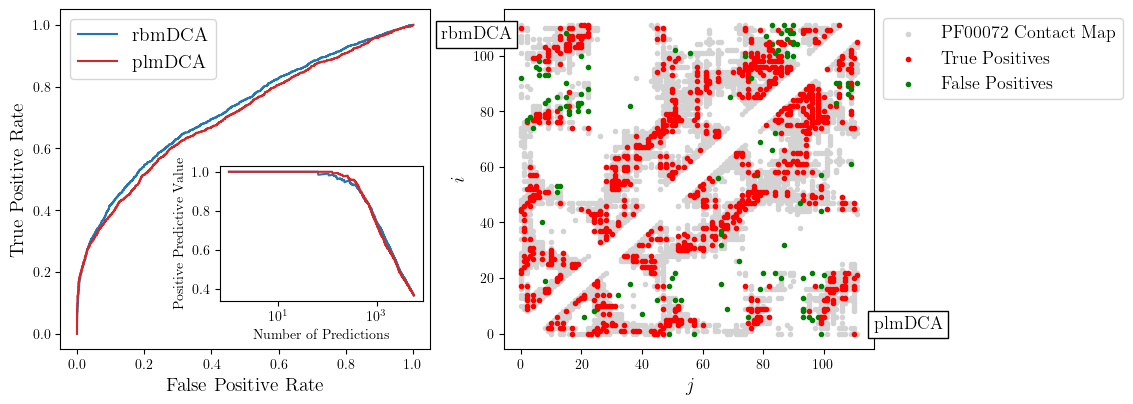

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10.5, 4.5), dpi=100) 
ax1, ax2 = axs.flatten()

# ROC and PPV curves
# rbm
fp_rbm, tp_rbm, s_roc_rbm = utils.ROC_curve_distance(distance_table, F2_table, k, threshold)
p_rbm, ppv_rbm, s_ppv_rbm = utils.PPV_curve_distance(distance_table, F2_table, k, threshold)
# plm
fp_plm, tp_plm, s_roc_plm = utils.ROC_curve_distance(distance_table, plm_table, k, threshold)
p_plm, ppv_plm, s_ppv_plm = utils.PPV_curve_distance(distance_table, plm_table, k, threshold)

# ROC curve
ax1.plot(fp_rbm, tp_rbm, label = 'rbmDCA')
ax1.plot(fp_plm, tp_plm, label = 'plmDCA', color='tab:red')
ax1.legend(fontsize=14)
ax1.set_xlabel('False Positive Rate', fontsize=14)
ax1.set_ylabel('True Positive Rate', fontsize=14)

# PPV curve
ax1b = inset_axes(ax1, width='55%', height='40%',
                  loc="lower right",
                  bbox_to_anchor=(0.0, 0.12, 1, 1),
                  bbox_transform=ax1.transAxes)
ax1b.plot(p_rbm, ppv_rbm)
ax1b.plot(p_plm, ppv_plm, color='tab:red')
ax1b.set_ylabel('Positive Predictive Value')
ax1b.set_xlabel('Number of Predictions')
ax1b.set_xscale('log')

# Let us look at residues pairs with strongest Frobenius norm
num_contacts_F2 = 500

# plotting true contacts 
pbar = tqdm(total=num_contacts, colour='White')
for k in range(num_contacts):   
    i, j = contact_table.iloc[k].name
    ax2.scatter(i, j, c='lightgray', marker='.', rasterized=True, label='PF00072 Contact Map')
    ax2.scatter(j, i, c='lightgray', marker='.', rasterized=True)
    pbar.update(1)
pbar.close()

pbar = tqdm(total=num_contacts_F2, colour='green')
for k in range(num_contacts_F2):
    
    # plotting F2 prediction
    i0, j0 = F2_table_mod.iloc[k].name
    condition0 = contact_table.loc[(i0,j0)]['if_contact']

    if condition0:
        ax2.scatter(i0, j0, c='red', marker='.',rasterized=True, label='True Positives')
    else:
        ax2.scatter(i0, j0, c='green', marker='.', rasterized=True, label='False Positives')
        
    # plotting plmDCA prediction
    i2, j2 = plm_table_mod.iloc[k].name
    condition2 = contact_table.loc[(i2,j2)]['if_contact']
    
    if condition2:
        ax2.scatter(j2, i2, c='red', marker='.', rasterized=True)
    else:
        ax2.scatter(j2, i2, c='green', marker='.', rasterized=True)
    
    pbar.update(1)
pbar.close()

ax2.set_xlabel(r'$j$', fontsize=14)
ax2.set_ylabel(r'$i$', fontsize=14)

# adding leyends
handles, labels = ax2.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Eliminar duplicados
ax2.legend(by_label.values(), by_label.keys(), 
          bbox_to_anchor=(1.0, 1.0), fontsize=13)

# adding labels: rbmDCA, plmDCA
ax2.text(-0.17, 0.95, 'rbmDCA', transform=ax2.transAxes, fontsize=13, verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='k'))
ax2.text(1.0, 0.05, 'plmDCA', transform=ax2.transAxes, fontsize=13, verticalalignment='bottom',
        bbox=dict(facecolor='white', edgecolor='k'))

plt.show()

# Improving the Gaussian Approximation

In [1], we demonstrated that the Gaussian approximation, as it was exposed above, fails when the norm of the weights $ \sqrt{\sum_{\mu} \big(W_{i_0 a}^{\mu}\big)^2}$ is significantly larger than those for other visible nodes $i \neq i_0$ conected to the same hidden node $a$. In such cases, one needs to refine the approximation made in Eq. $(11)$, and replace the tensor associated with that hidden node as: 
$$
\begin{align}
{T_a}_{i_1 i_2}^{\mu'_1 \mu'_2} \to \frac{1}{q} \sum_{\mu'_{0}} \int_{-\infty}^{\infty} Dz \ \ln \left( 1 + e^{c_a + \hat{W}_{i_1 a}^{\mu'_1} + \hat{W}_{i_2 a}^{\mu'_2} + \hat{W}_{i_0 a}^{\mu'_0} + \sqrt{q^{-1} \sum_{j (\neq i_1, i_2, i_0)} \sum_\mu \big(\hat{W}_{ja}^{\mu} \big)^2 } \ z } \right) = \frac{1}{q} \sum_{\mu'_{0}} {T_a}_{i_1 i_2 i_0}^{\mu'_1 \mu'_2 \mu'_0}.
\tag{16}
\end{align}
$$

In general, to apply this refining in general ones needs a function to compute:
$$
{T_a}_{i_1 \dots i_n }^{\mu'_1 \dots \mu'_n} = \int_{-\infty}^{\infty} Dz \ \ln \left( 1 + e^{c_a + \sum_{k=1}^{n} \hat{W}_{i_k a}^{\mu'_k} + \sqrt{q^{-1} \sum_{j (\neq i_k : 1 \le k \le n)} \sum_\mu \big(\hat{W}_{ja}^{\mu} \big)^2 } \ z } \right) = \frac{1}{q} \sum_{\mu'_{0}} {T_a}_{i_1 i_2 i_0}^{\mu'_1 \mu'_2 \mu'_0}.
\tag{17}
$$
In the following, we implement such a function and another one to compute the pairwise couplings using this apprximation.

In [18]:
def Tn_zs(W: Tensor, 
          c: Tensor, 
          v_list: list, 
          n_sigma: float,
          n_steps: int) -> Tensor:
    """
    Compute a n-rank tensor which is a generalization of Eqs. (8), (10), and (12).
    
    Args:
        W (Tensor): Weight matrix (shape: q x Nv x Nh).
        c (Tensor): Hidden fields (shape: Nh).
        v_list: Visible sites index list.
        n_sigma (float): Set the wide of the numerical integral in terms of the scale parameter of the gaussian.
        n_steps (int): Number of steps of the numerical integral.

    Returns:
        Tensor: n-rank tensor (shape: q^n).
    """

    q = W.shape[0]
    n = len(v_list)
    sd_raw = torch.sum(W**2, dim=(0,1)) 
    bias = c
    for k, i in enumerate(v_list):
        Wk = W[:, i, :]
        bias = utils.k_unsqueeze(Wk, n, k) + bias
        sd_raw -= torch.sum(Wk**2, dim=0) 
        
    return est_gaussian_avg(f = softplus,
                            loc = bias,
                            scale = torch.sqrt(sd_raw/q),
                            n_sigma = n_sigma,
                            n_steps = n_steps,
                           ) # shape: q^n

def J2_zs_mod(W_a: Tensor,
              c_a: Tensor,
              i1: int, 
              i2: int,
              v_list: list,
              n_sigma: float,
              n_steps: int) -> Tensor:
    """
    Compute the efective pairwise couplings between sites i1, i2 considering 
    outiliers in v_list.
    
    Args:
        W_a (Tensor): Weight matrix (shape: q x Nv).
        c_a (float): Hidden field (shape: Nh).
        i1, i2 (int): Visible sites indexes 1 and 2.
        v_list (list): sites of  outliers.
        n_sigma (float): Set the wide of the numerical integral in terms of the 
            scale parameter of the gaussian.
        n_steps (int): Number of steps of the numerical integral.

    Returns:
        Tensor: 2-rank pairwise coupling tensor between sites i1, i2 (shape: q x q).
    """
    
    index_list = list(OrderedDict.fromkeys([i1, i2] + v_list))
    T2_zs_mod = Tn_zs(W_a, c_a, index_list, n_sigma, n_steps)
    n = T2_zs_mod.dim()
    for _ in range(2,n):
        T2_zs_mod = T2_zs_mod.mean(axis=-1) 
    J2_zs = (T2_zs_mod + T2_zs_mod.mean()
             - T2_zs_mod.mean(dim=0).unsqueeze(0) 
             - T2_zs_mod.mean(dim=1).unsqueeze(1))
     
    return J2_zs

## Inverse Experiment

To check the validity of our refined approximation we will compare it with that of the simple Gaussian approximation in the inverse Blume-Capel problem (also reference in [1]).

In [19]:
# Loading a model
model_fname = './models/Blume_PCD-50_mbs=1000_lr=0.1_Nh=250.h5'

# selecting an update to observe
update = utils.get_saved_updates(model_fname)[-1]
W_2, b_2, c_2 = utils.get_model_params(model_fname, 
                                       update, 
                                       device='cuda:0', 
                                       dtype=torch.float32)

# it is important to fix the zero-sum gauge in the RBM to get accurate results!
utils.fix_gauge_RBM(W_2, b_2, c_2, gauge='zero-sum')

In [20]:
# computating all couplings
q, Nv, _ = W_2.shape
J2_matrix_2 = np.zeros((q,q,Nv,Nv))
pbar = tqdm(total=int(Nv*(Nv-1)/2), colour='green')
for i1 in range(1, Nv):
    for i2 in range(i1):
        J2_torch = J2_zs(W_2, c_2, i1, i2, n_sigma=5, n_steps=20)
        J2_matrix_2[:,:, i1, i2] = J2_torch.to('cpu').numpy()
        pbar.update(1)
pbar.close()

J2_matrix_2 = J2_matrix_2 + J2_matrix_2.transpose(1,0,3,2)
# This cell runs in < 3s (in an NVIDIA Geforce RTX 3090 GPU)

100%|██████████| 1275/1275 [00:02<00:00, 573.14it/s]


In [21]:
# looking for outliers
outliers_dict = utils.create_outliers_dict(W_2.to('cpu').numpy(), 
                                           z_score_threshold=2.5)

# computing couplings correction using the outliers 
q, Nv, Nh = W_2.shape
J2_matrix_corr = np.zeros((q,q,Nv,Nv))
pbar = tqdm(total=Nh, colour='green')

for a in range(Nh):
    W_a = W_2[:,:,a].unsqueeze(-1)
    c_a = c_2[a].unsqueeze(-1)
    v_list = outliers_dict[a]
    if len(v_list) > 0:
        for i1 in range(1, Nv):
            for i2 in range(i1):
                J2_tensor_mod = J2_zs_mod(W_a, c_a, i1, i2, v_list, n_sigma=5, n_steps=20)
                J2_tensor = J2_zs(W_a, c_a, i1, i2, n_sigma=5, n_steps=20)
                J2_matrix_corr[:,:, i1, i2] += (J2_tensor_mod - J2_tensor).to('cpu').numpy()
    pbar.update(1)
pbar.close()
J2_matrix_corr = J2_matrix_corr + J2_matrix_corr.transpose(1,0,3,2)

# This cell runs in ~ 6min 30s (in an NVIDIA Geforce RTX 3090 GPU)

100%|██████████| 250/250 [06:38<00:00,  1.59s/it]


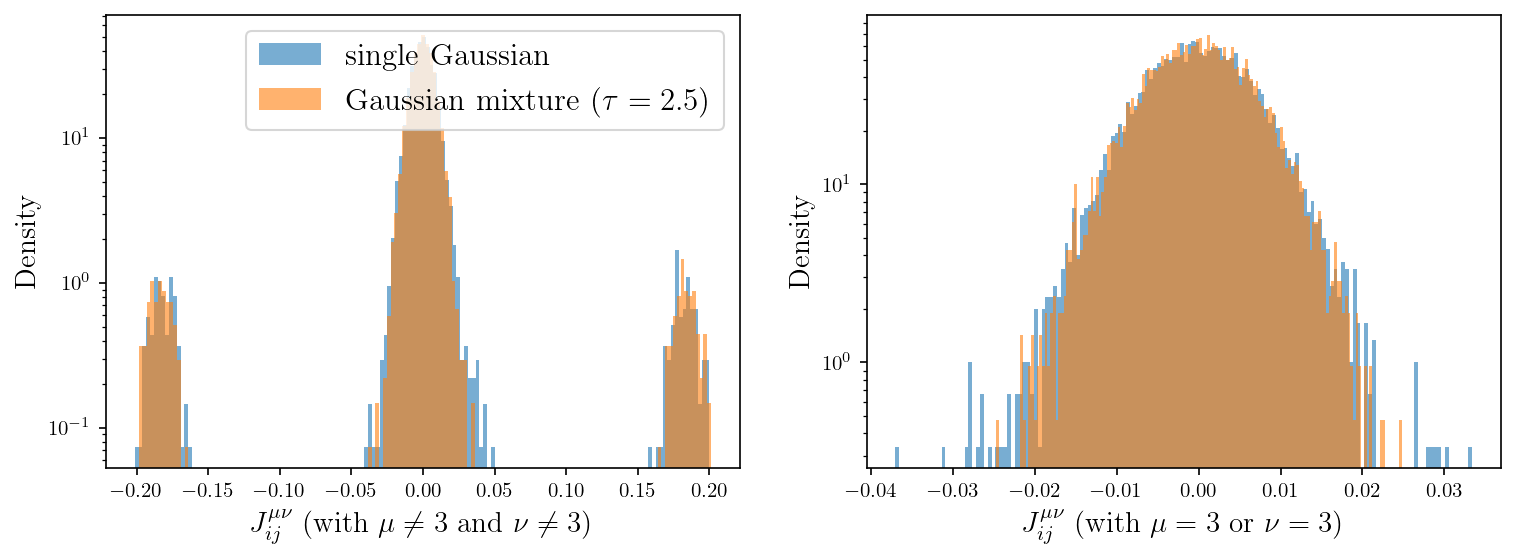

In [22]:
# Plotting results
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=150 )
ax1, ax2 = axs.flatten()
 
# non-zero couplings
ax1.hist(utils.couplings_non_zero(J2_matrix_2), log=True, bins=150, alpha=0.6, label= 'single Gaussian', density=True)
ax1.hist(utils.couplings_non_zero(J2_matrix_2 + J2_matrix_corr), log=True, bins=150, alpha=0.6, label= r'Gaussian mixture ($\tau=2.5$)', density=True)
ax1.set_xlabel(r'$J_{ij}^{\mu \nu}$ (with $\mu \neq 3$ and $\nu \neq 3$)', fontsize=14)

# zero-couplings
ax2.hist(utils.couplings_zero(J2_matrix_2), log=True, bins=150, alpha=0.6, label= 'single Gaussian', density=True)
ax2.hist(utils.couplings_zero(J2_matrix_2 + J2_matrix_corr), log=True, bins=150, alpha=0.6, label= r'Gaussian mixture ($\tau=2.5$)', density=True)
ax2.set_xlabel(r'$J_{ij}^{\mu \nu}$ (with $\mu = 3$ or $\nu = 3$)', fontsize=14)

for ax in axs:    
    ax.set_ylabel(r'Density', fontsize=14)
ax1.legend(fontsize=15)
plt.show()

# References

1. Decelle, A., Navas Gómez, A. J., & Seoane, B. (2025). Inferring Higher-Order Couplings with Neural Networks. [_Physical Review Letters_, 135, 207301](https://doi.org/10.1103/lyny-6r9y).
2. Ekeberg, M., Lövkvist, C., Lan, Y., Weigt, M., & Aurell, E. (2013). Improved contact prediction in proteins: using pseudolikelihoods to infer Potts models.[ _Physical Review E—Statistical, Nonlinear, and Soft Matter Physics_, 87(1), 012707](https://doi.org/10.1103/PhysRevE.87.012707).
3. Ekeberg, M., Hartonen, T., & Aurell, E. (2014). Fast pseudolikelihood maximization for direct-coupling analysis of protein structure from many homologous amino-acid sequences. [_Journal of Computational Physics_, 276, 341-356](https://doi.org/10.1016/j.jcp.2014.07.024).